# Dealing with uncertainty using deep quantile regression

Code used in the blog: https://www.yuritan.nl/posts/prediction_uncertainty/. For more in-depth explaination, please check out the blog!

In [14]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

from functools import partial
from scipy import stats, interpolate
from src.data import generate_dataset
from src.visualization import beautify_ax

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating data
Generating a dataset with a increasing variance. This allows to demonstrate differences in uncertainty, which should be higher when x increases.

In [56]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

## Plotting the data

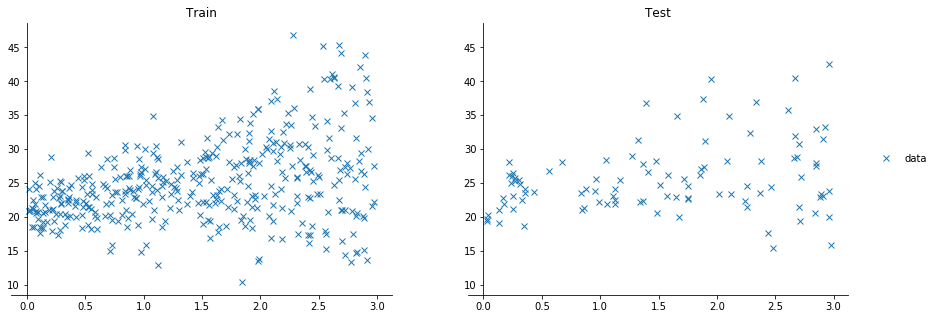

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data
To make sure the feature $x$ and target $y$ are in the same scale

In [58]:
mmsx = MinMaxScaler().fit(x)
x, x_test = mmsx.transform(x), mmsx.transform(x_test)

mmsy = MinMaxScaler().fit(y)
y, y_test = mmsy.transform(y), mmsy.transform(y_test)

## Quantile regression neural network, using MCDropout
As you can see below, I've implemented a slightly different dropout. This dropout creates a random mask for a single row in the batch, and then broadcasts this over all rows in the batch. This is needed since we are trying to create a linear regression. Try to use normal `nn.Dropout()` and see what happends. Then the dropout will be different for all x coordinates of the line (which therefore results in a noisy line). 

In [164]:
class Dropout_on_dim(torch.nn.modules.dropout._DropoutNd):
    """ Dropout that masks the (hidden) features equally over a batch """
    def __init__(self, p, dim=1, **kwargs):
        super().__init__(p, **kwargs)
        self.dropout_dim = dim
        self.multiplier_ = 1.0 / (1.0-self.p)  # normalize for dropout rate
        
    def forward(self, X):
        mask = torch.bernoulli(
                X.new(X.size(self.dropout_dim)).fill_(1-self.p)
        )
        return X * mask * self.multiplier_
    
class DeepQuantileRegression(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.quantiles = params['quantiles']
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities, but not
            Dropout_on_dim(params['dropout_p'], dim=params['dropout_dim']),
            nn.Linear(params['hidden_size'], len(params['quantiles']))
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr'], 
            weight_decay=params['weight_decay']
        )
    
    def forward(self, X):
        return self.model_(X)
    
    def mc_predict(self, X, samples=4000):
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1)
        return preds
    
    def save(self, path, fname):
        torch.save({
            "model_state_dict": self.model_.state_dict(),
            "optim_state_dict": self.optim_.state_dict(),
        }, os.path.join(path, fname))
    
    def load(self, path, fname):
        checkpoint = torch.load(os.path.join(path, fname))
        self.model_.load_state_dict(checkpoint['model_state_dict'])
        self.optim_.load_state_dict(checkpoint['optim_state_dict'])
        return self

## Loss and utility functions
- Created a quantile loss function that calculates the loss for all quantiles. 
- A functions that helps creating (evenly spaced) array of 'quantiles'. 

In [189]:
def QuantileLoss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0), f'preds.size:{preds.shape} target.size:{quantiles.shape}'
    assert preds.size(1) == quantiles.shape[0], f'preds.size:{preds.shape} quantiles.shape:{quantiles.shape}'

    def _tilted_loss(q, e):
        return torch.max((q-1) * e, q * e).unsqueeze(1)

    err = target - preds
    losses = [_tilted_loss(q, err[:, i])  # calculate per quantile
              for i, q in enumerate(quantiles)]

    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss    

    
def create_quantiles(n, min_q=0.01, max_q=0.99):
    """ Create array of (evenly spaced) quantiles, given desired number of quantiles. """
    n -= 2  # because we add the lowest and highest quantiles manually
    n_equally_spaced = np.linspace(1 / (n + 1), 1 - 1 / (n + 1), n)
    quantiles = np.concatenate([np.array([min_q]), 
                                n_equally_spaced, 
                                np.array([max_q])])
    return quantiles

## Model setup
Predicting for multiple evenly spaced quantiles with an lower limit of `0.01` and upper limmit of `0.99`. These parameters are selected by trying out some configurations manually. You could of course optimize this. 

In [166]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
print(f"Used quantiles: {QUANTILES}")
params = {
    'input_size': 1,
    'hidden_size': 128,
    'dropout_p': 0.2,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 2001,
    'lr': 1e-4,
    'weight_decay': 1e-6,
}
model = DeepQuantileRegression(params)
criterion = partial(QuantileLoss, quantiles=QUANTILES)

Used quantiles: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]


## Training the model

In [212]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

In [168]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(x_train), y_train)
            val_loss = criterion(model(x_val), y_val)
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f}")

Epoch: 0 	 Train loss:2.19807 	 Val loss: 2.29200
Epoch: 100 	 Train loss:0.58862 	 Val loss: 0.51428
Epoch: 200 	 Train loss:0.48972 	 Val loss: 0.44156
Epoch: 300 	 Train loss:0.44884 	 Val loss: 0.43159
Epoch: 400 	 Train loss:0.42372 	 Val loss: 0.39746
Epoch: 500 	 Train loss:0.40288 	 Val loss: 0.38922
Epoch: 600 	 Train loss:0.40732 	 Val loss: 0.38248
Epoch: 700 	 Train loss:0.40114 	 Val loss: 0.39951
Epoch: 800 	 Train loss:0.40840 	 Val loss: 0.39248
Epoch: 900 	 Train loss:0.40279 	 Val loss: 0.37424
Epoch: 1000 	 Train loss:0.40077 	 Val loss: 0.38806
Epoch: 1100 	 Train loss:0.40379 	 Val loss: 0.38063
Epoch: 1200 	 Train loss:0.41033 	 Val loss: 0.37485
Epoch: 1300 	 Train loss:0.40967 	 Val loss: 0.38107
Epoch: 1400 	 Train loss:0.41020 	 Val loss: 0.37523
Epoch: 1500 	 Train loss:0.40652 	 Val loss: 0.38010
Epoch: 1600 	 Train loss:0.40783 	 Val loss: 0.38449
Epoch: 1700 	 Train loss:0.41122 	 Val loss: 0.38305
Epoch: 1800 	 Train loss:0.40168 	 Val loss: 0.39167
Epoch

## Saving model state

In [169]:
model.save(path='../models/', fname='deep_quantile_regression.pth')

In [170]:
model = DeepQuantileRegression(params)
model.load(path='../models/', fname='deep_quantile_regression.pth')

DeepQuantileRegression(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Dropout_on_dim(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=11, bias=True)
  )
)

## Check if custom dropout layer works as intended
Where every row is masked equally and every column masked randomly

In [171]:
x_zeros_test = torch.zeros(x_val.shape)
preds_test = model.mc_predict(x_zeros_test, samples=4000).numpy()

In [188]:
assert np.array_equal(preds_test[0, :, :], preds_test[1, :, :]) == True  # every row in batch is masked equally
assert np.array_equal(preds_test[:, :, 0], preds_test[:, :, 1]) == False  # but randomly masked per batch

## Predict
Predicts in the train set in this case for visualization purposes

In [190]:
qr_preds = model.mc_predict(x_train, samples=4000).numpy()
qr_preds.shape

(400, 11, 4000)

## Sorting for plotting

In [191]:
sorted_index = x_train.argsort(dim=0).flatten()
x_, y_hat = x_train[sorted_index].numpy(), qr_preds[sorted_index, :, :]
x_.shape, y_hat.shape

((400, 1), (400, 11, 4000))

## Extra quantile utility function
Since our model predicts a finite number of quantiles, we don't have a continuous CDF / cdf function. Therefore, I use a simple linear interpolation function from Scipy to generate the predictions in between the quantile predictions.

In [ ]:
def get_quantile_pred(q, used_quantiles, preds):
    interp_cdf = interpolate.interp1d(used_quantiles, preds, fill_value='extrapolate')
    return interp_cdf(q)

## Calculating median and (95%) credible interval
- quantile 0.975 equals $\mu + 2*\sigma$
- quantile 0.025 equals $\mu - 2*\sigma$

In [180]:
q_975 = np.array([
    get_quantile_pred(q=.975, used_quantiles=QUANTILES, preds=y_hat[..., i]) 
    for i in range(y_hat.shape[-1])
]).T

q_025 = np.array([
    get_quantile_pred(q=.025, used_quantiles=QUANTILES, preds=y_hat[..., i]) 
    for i in range(y_hat.shape[-1])
]).T

median_i = int(QUANTILES.shape[-1]/2)
q_50 = y_hat[:, median_i, :]

## Ploting interval to see the 'fit'
Plotting multiple lines to see the uncertainty of the median/upper/lower intervals. In this plot, you can see therefore both aleatoric and epistemic uncertainty.

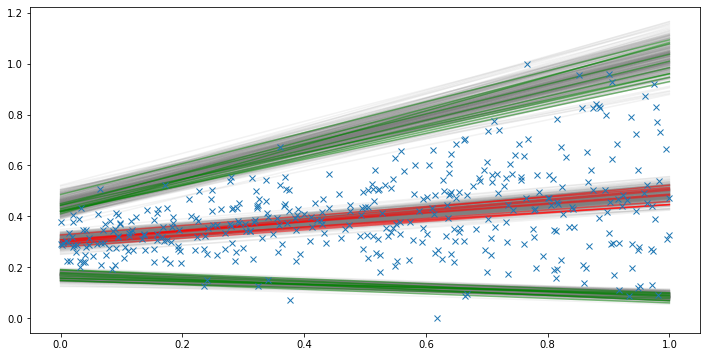

In [208]:
plt.figure(figsize=(12, 6))
n = 300  # plotting lots of lines to show the uncertainty in the median and upper/lower intervals
n_c = 10  # to make a select number of lines colorful

plt.plot(x_, q_025[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_50[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_975[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_025[:, n:n+n_c], c='g', alpha=.5)
plt.plot(x_, q_50[:, n:n+n_c], c='r', alpha=.5)
plt.plot(x_, q_975[:, n:n+n_c], c='g', alpha=.5)

plt.plot(x, y, 'x')
plt.show();

## Looking at individual predictions (CDFs)
First, predicting on the validation set and sort them

In [217]:
preds_val = model.mc_predict(x_val, samples=4000).numpy()
s_i = x_val.argsort(dim=0).flatten()
x_val_, y_hat_val = x_val[s_i].numpy(), preds_val[s_i, :, :]

And of course plot the CDFs

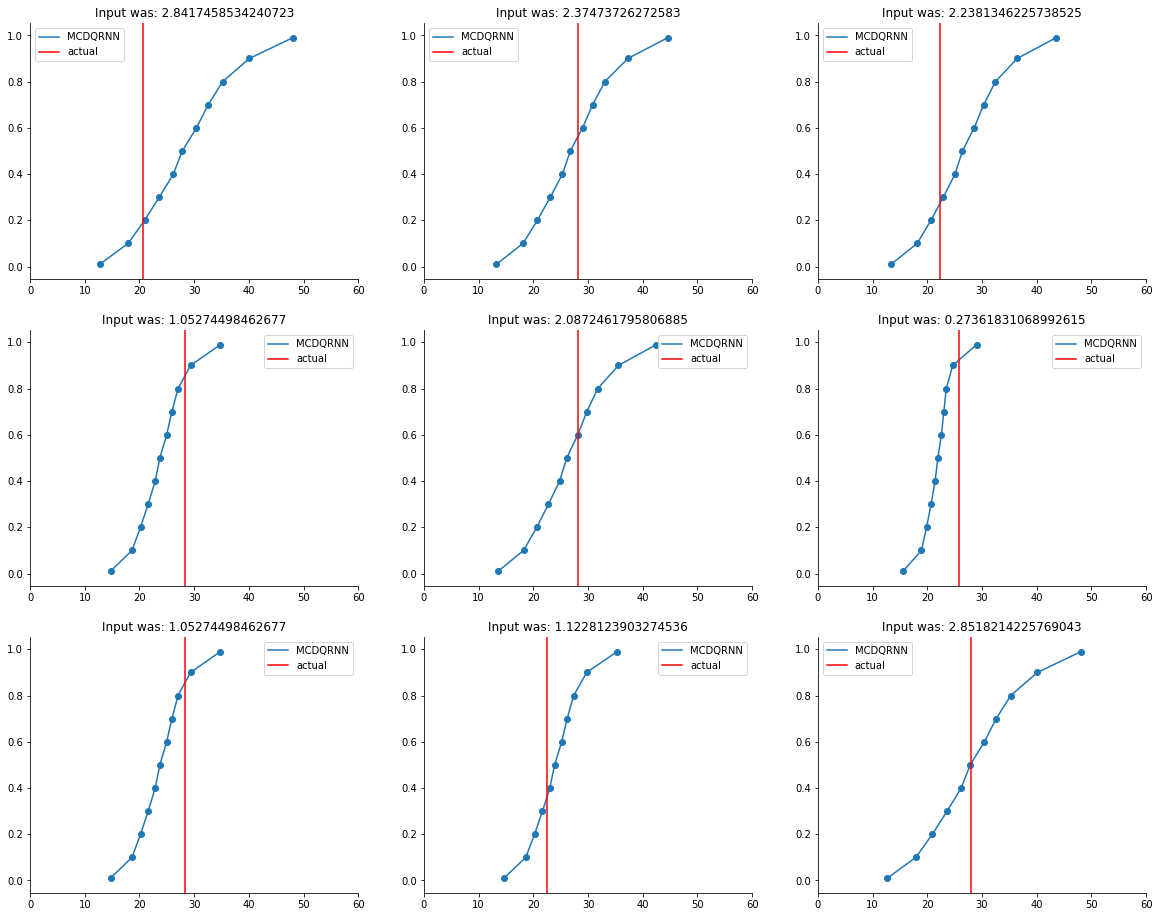

In [233]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
org_x = mmsx.inverse_transform(x_val_)
org_y = mmsy.inverse_transform(y_val[s_i])
inv_y_hat_val = mmsy.inverse_transform(np.mean(y_hat_val, axis=-1))

for ax in axes.flat:
    ax = beautify_ax(ax)
    i = np.random.randint(0, x_val.shape[0])
    ax.plot(inv_y_hat_val[i], QUANTILES, label='MCDQRNN')
    ax.scatter(inv_y_hat_val[i], QUANTILES)
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i][0]}")
    ax.set_xlim(0,60)
    ax.legend();

## Aiming for the approximate posterior predictive distribution
Now we have many samples (with Dropout enabled) from every prediction. We can samples from those samples (uniformly) to create a distribution that includes both aleatoric (quantile regression) and epistemic (MCDropout) uncertainty.

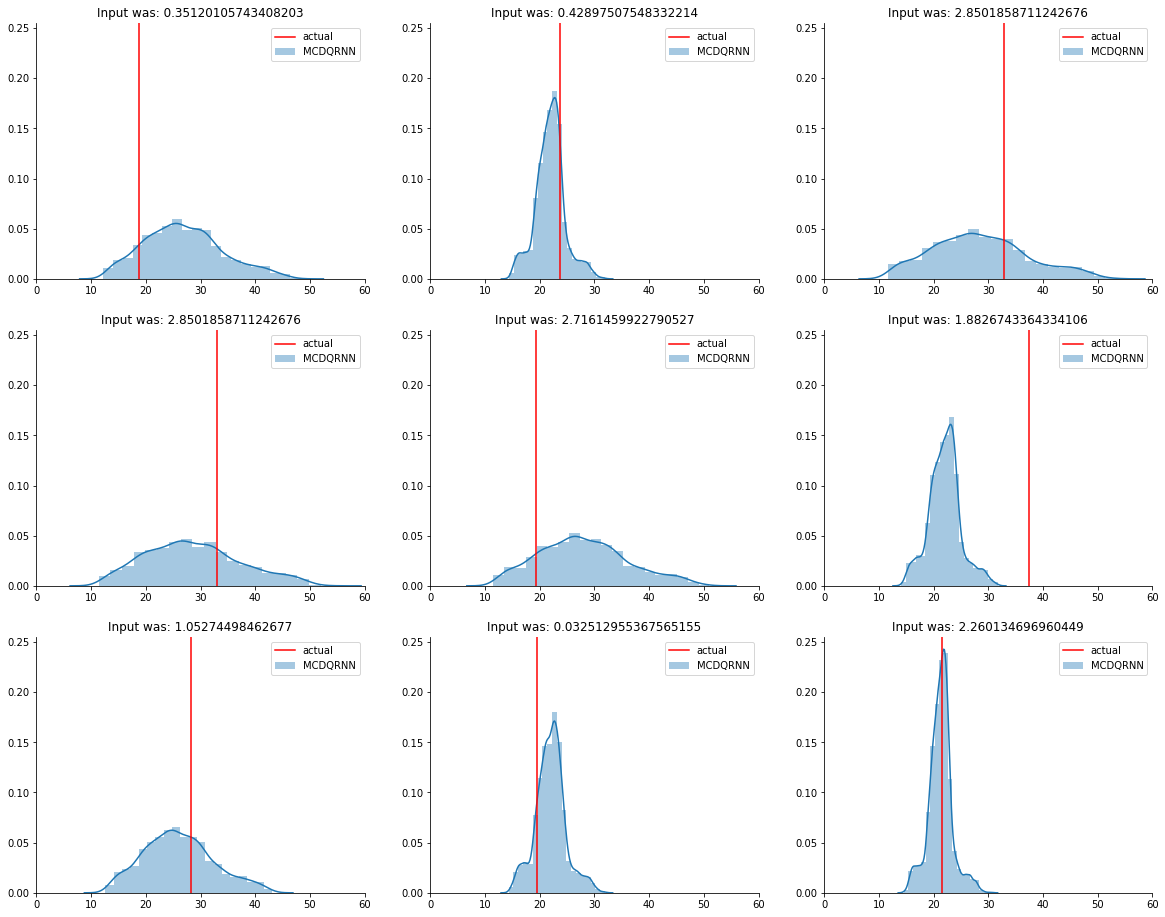

In [234]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for ax in axes.flat:
    i = np.random.randint(0, preds_val.shape[0])
    ax = beautify_ax(ax)
    
    mcd_qrnn_posterior = np.array([
        get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=preds_val[i, :, s])
        for s in range(preds_val.shape[-1])  # sample from all samples
    ])
    mcd_qrnn_posterior = mmsy.inverse_transform(mcd_qrnn_posterior.reshape(-1,1))
    
    sns.distplot(mcd_qrnn_posterior, bins=20, ax=ax, label='MCDQRNN');
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i][0]}")
    ax.set_xlim(0,60)
    ax.legend()
    
plt.show()

It sometimes makes errors unfortunately, but you can see a relation between the input $x$ and the width of the distribution.